## SIPA 08 EAST

## Import the Libraries

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt
from imutils.object_detection import non_max_suppression # Used to select the best bounding boxes
import sys
sys.path.append('../functions')

import ad_functions as adfns


import pytesseract
config_tesseract = '--tessdata-dir ttesseract_langs --psm 7'

In [32]:
def read_input_file_list():
    input_data = pd.read_csv('sipa08_files.txt', names=["file_name","seen_value","ncol2","ncol3"], sep="\t", header=None)
    input_data = input_data.reset_index()

    print(len(input_data), "input images")
    return input_data

In [4]:
file_path = "./sipaimages/8/"
file_list = os.listdir(file_path)

In [24]:
file_path = "./sipaimages/8/"
file_list = os.listdir(file_path)

full_paths = [os.path.join(file_path, file) for file in file_list]

In [25]:
ic(full_paths)

ic| full_paths: ['./sipaimages/8/1.jpg',
                 './sipaimages/8/2.jpg',
                 './sipaimages/8/3.jpg',
                 './sipaimages/8/4.jpg',
                 './sipaimages/8/43178_20220517100916.jpg',
                 './sipaimages/8/43178_20220517100930.jpg',
                 './sipaimages/8/43178_20220517100957.jpg',
                 './sipaimages/8/43181_20220517101047.jpg',
                 './sipaimages/8/43347_20220517130953.jpg',
                 './sipaimages/8/43347_20220517131028.jpg',
                 './sipaimages/8/43350_20220517131058.jpg',
                 './sipaimages/8/43356_20220517131147.jpg',
                 './sipaimages/8/43359_20220517131209.jpg',
                 './sipaimages/8/5.jpg',
                 './sipaimages/8/7.jpg']


['./sipaimages/8/1.jpg',
 './sipaimages/8/2.jpg',
 './sipaimages/8/3.jpg',
 './sipaimages/8/4.jpg',
 './sipaimages/8/43178_20220517100916.jpg',
 './sipaimages/8/43178_20220517100930.jpg',
 './sipaimages/8/43178_20220517100957.jpg',
 './sipaimages/8/43181_20220517101047.jpg',
 './sipaimages/8/43347_20220517130953.jpg',
 './sipaimages/8/43347_20220517131028.jpg',
 './sipaimages/8/43350_20220517131058.jpg',
 './sipaimages/8/43356_20220517131147.jpg',
 './sipaimages/8/43359_20220517131209.jpg',
 './sipaimages/8/5.jpg',
 './sipaimages/8/7.jpg']

In [36]:
def read_input_file(input_file):
    return cv2.imread(input_file)

In [12]:
def delete_existing_output():
    file_path = "./roi_sipaimages/"
    if os.path.exists(file_path):
        # removing the file using the os.remove() method
        shutil.rmtree(file_path)

## Program Control Variables

In [33]:
# Model to be used
detector = './models/frozen_east_text_detection.pb'

# Load the model
net = cv2.dnn.readNet("./models/frozen_east_text_detection.pb")

# Optimal shape of image to send to the neural network - EAST requires a multiple of 32
control_width, control_height = 320, 320 

input_data = read_input_file_list()

# Used to filter the EAST returns so only the best are returned
min_confidence = 0.9 


layers_names = []

# feature_fusion/Conv_7/Sigmoid - this layer will return a confidence value between 0 and 1 and for this it uses the Sigmoid function.
layers_names.append('feature_fusion/Conv_7/Sigmoid')

# feature_fusion/concat_3 - will return a score map which is the confidence of the detections and also the geometry of the bounding boxes.
layers_names.append('feature_fusion/concat_3')

15 input images


In [7]:

# Create the neural network. Accessed using the dnn (Deep Neural Network)
neural_network = cv2.dnn.readNet(detector)



In [8]:
def geometric_data(geometry, y):
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  
  angles_data = geometry[0, 4, y]
  return angles_data, xData0, xData1, xData2, xData3

In [9]:
def geometric_calculation(x, y, angles_data, xData0, xData1, xData2, xData3):

    # Compute the offset factor - the resulting feature maps will be 4 times smaller than the input image
    (offsetX, offsetY) = (x * 4.0, y * 4.0)

    # Extract the rotation angle for the prediction
    angle = angles_data[x]

    # Compute the Cosine and Sine
    cos = np.cos(angle)
    sin = np.sin(angle)

    # Use the geometry volume to derive the width and height of the bounding box
    h = xData0[x] + xData2[x]
    w = xData1[x] + xData3[x]

    # Compute the ending (x, y) coordinates for the text prediction bounding box
    endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
    endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))

    # Compute the starting (x, y) coordinates for the text prediction bounding box
    beginX = int(endX - w)
    beginY = int(endY - h)

    return beginX, beginY, endX, endY

In [10]:
def EAST_process(img):

    # Take a copy of the image prior to alterations
    img_copy = img.copy()
    original = img.copy()

    # Set the Region of Interest image to None as if EAST has a problem, then this will not be captured.
    roi = None

    # Resize the image
    img = cv2.resize(img, (control_width, control_height))

    H = img.shape[0]
    W = img.shape[1]
    
    # Get the proportions of the image for implementation of the bounding boxes.
    proportion_W = W / float(control_width)
    proportion_H = H / float(control_height)

    # blob - Binary Large Object
    blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), swapRB = True, crop = False)

    # Send the blob to the neural network
    neural_network.setInput(blob)

    # Get scores and predictions
    scores, geometry = neural_network.forward(layers_names)
    rows, columns = scores.shape[2:4]

    # Initialise the boxes and confidence variables.
    boxes = []
    confidences = []

    # Loop through the detected shapes
    for y in range(0, rows):

        data_scores = scores[0, 0, y]
        angles_data, xData0, xData1, xData2, xData3 = geometric_data(geometry, y)

        # Loop through the detected rows
        for x in range(0, columns):

            # If the confidence score is under the minimum then ignore
            if data_scores[x] < min_confidence:
                # print(data_scores[x])
                continue

            beginX, beginY, endX, endY = geometric_calculation(x, y, angles_data, xData0, xData1, xData2, xData3)
            confidences.append(data_scores[x])
            boxes.append((beginX, beginY, endX, endY))

    # Suppress the weak overlapping bounding boxes using imutils' non_max_suppression
    detections = non_max_suppression(np.array(boxes), probs = confidences)

    for (beginX, beginY, endX, endY) in detections:
        #print(beginX, beginY, endX, endY)
        beginX = int(beginX * proportion_W)
        beginY = int(beginY * proportion_H)
        endX = int(endX * proportion_W)
        endY = int(endY * proportion_H)

        # region of interest
        roi = img_copy[beginY:endY, beginX:endX]

        cv2.rectangle(original, (beginX, beginY), (endX, endY), (0,255,0), 2)

    return roi

In [34]:
ic(input_data[1][1])

KeyError: 1

In [37]:

delete_existing_output()
not_written = []
written = []
unusual = []

# Loop through the input file list
for row in input_data.iterrows():

    input_file = row[1][1]
    

    path, file = os.path.split(os.path.abspath(input_file))

    # print(input_file)
    
    img = read_input_file(input_file)

    roi = EAST_process(img)
    
    new_path = "./roi_" + input_file.split(os.path.sep)[-3] + "/" + input_file.split(os.path.sep)[-2] + "/"
    new_file = "roi_" + file

    if not os.path.exists(new_path):
        os.makedirs(new_path)


    file_name = new_path + new_file

    if roi is None:
        not_written.append(file_name)
        continue

    if len(roi)==0:
        not_written.append(file_name)
        continue

    if len(roi[0])!=0:
        written.append(file_name)
        cv2.imwrite(file_name, roi)
    else:
        unusual.append(file_name)
        # print(file_name)


    


    

In [38]:
def text_detector(image):

	textRecongized = None
	textDetected = None
	orig = image
	(H, W) = image.shape[:2]

	# (newW, newH) = (320, 320)
	(newW, newH) = (320, 320)
	rW = W / float(newW)
	rH = H / float(newH)

	image = cv2.resize(image, (newW, newH))
	(H, W) = image.shape[:2]

	# print(H, W)

	layerNames = [
		"feature_fusion/Conv_7/Sigmoid",
		"feature_fusion/concat_3"]


	blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
		(123.68, 116.78, 103.94), swapRB=True, crop=False)

	net.setInput(blob)
	(scores, geometry) = net.forward(layerNames)

	(numRows, numCols) = scores.shape[2:4]
	rects = []
	confidences = []

	for y in range(0, numRows):

		scoresData = scores[0, 0, y]
		xData0 = geometry[0, 0, y]
		xData1 = geometry[0, 1, y]
		xData2 = geometry[0, 2, y]
		xData3 = geometry[0, 3, y]
		anglesData = geometry[0, 4, y]

		# loop over the number of columns
		for x in range(0, numCols):
			# if our score does not have sufficient probability, ignore it
			if scoresData[x] < 0.5:
				continue

			# compute the offset factor as our resulting feature maps will
			# be 4x smaller than the input image
			(offsetX, offsetY) = (x * 4.0, y * 4.0)

			# extract the rotation angle for the prediction and then
			# compute the sin and cosine
			angle = anglesData[x]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# use the geometry volume to derive the width and height of
			# the bounding box
			h = xData0[x] + xData2[x]
			w = xData1[x] + xData3[x]

			# compute both the starting and ending (x, y)-coordinates for
			# the text prediction bounding box
			endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
			endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
			startX = int(endX - w)
			startY = int(endY - h)

			# add the bounding box coordinates and probability score to
			# our respective lists
			rects.append((startX, startY, endX, endY))
			confidences.append(scoresData[x])

	boxes = non_max_suppression(np.array(rects), probs=confidences)

	for (startX, startY, endX, endY) in boxes:

		startX = int(startX * rW)
		startY = int(startY * rH)
		endX = int(endX * rW)
		endY = int(endY * rH)
		boundary = 2

		text = orig[startY-boundary:endY+boundary, startX - boundary:endX + boundary]

		# print(len(text[0]))

		if len(text[0])==0:
			return None, None
		
		text = cv2.cvtColor(text.astype(np.uint8), cv2.COLOR_BGR2GRAY)
		textRecongized = pytesseract.image_to_string(text)
		cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 3)
		orig = cv2.putText(orig, textRecongized, (endX,endY+5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA) 
	return orig, textRecongized


In [42]:
# new

delete_existing_output()
not_written = []
written = []
unusual = []

# Loop through the input file list
for row in input_data.iterrows():

	input_file = row[1][1]
	# print(input_file)

	# if (input_file==".\sipaimages\9\5.jpg"):
		# print(input_file)

	path, file = os.path.split(os.path.abspath(input_file))

	# if file=="5.jpg":
		# print("Aidan")

	# print(input_file)

	img = read_input_file(input_file)

	img = adfns.mask_green(img)

	# roi = EAST_process(img)

	imageO = cv2.resize(img, (640,320), interpolation = cv2.INTER_AREA)
	orig = cv2.resize(img, (640,320), interpolation = cv2.INTER_AREA)
	# textDetected, textpy = text_detector(imageO)
	textDetected, textpy = text_detector(img)

	new_path = "./roi_" + input_file.split(os.path.sep)[-3] + "/" + input_file.split(os.path.sep)[-2] + "/"
	new_file = "roi_" + file

	if not os.path.exists(new_path):
		os.makedirs(new_path)

	file_name = new_path + new_file

	if textDetected is None:
		not_written.append(file_name)
		continue

	if len(textDetected)==0:
		not_written.append(file_name)
		continue

	if len(textDetected[0])!=0:
		written.append(file_name)
		cv2.imwrite(file_name, textDetected)
	else:
		unusual.append(file_name)
		# print(file_name)






In [41]:
len(written), len(not_written), len(unusual)


(15, 0, 0)

In [11]:
not_written

['./roi_sipaimages/9/roi_5.jpg',
 './roi_sipaimages/2/roi_11.jpg',
 './roi_sipaimages/2/roi_14.jpg',
 './roi_sipaimages/2/roi_22421_20220321160735.jpg',
 './roi_sipaimages/2/roi_22431_20220322130331.jpg',
 './roi_sipaimages/2/roi_22431_20220322130602.jpg',
 './roi_sipaimages/2/roi_22431_20220322130947.jpg',
 './roi_sipaimages/2/roi_22432_20220322133052.jpg',
 './roi_sipaimages/2/roi_22438_20220324141106.jpg',
 './roi_sipaimages/2/roi_22440_20220324143411.jpg',
 './roi_sipaimages/2/roi_23033_20220328104942.jpg',
 './roi_sipaimages/2/roi_27273_20220414104049.jpg',
 './roi_sipaimages/2/roi_42539_20220504111717.jpg',
 './roi_sipaimages/2/roi_42539_20220504111812.jpg',
 './roi_sipaimages/2/roi_42541_20220504111842.jpg',
 './roi_sipaimages/2/roi_42545_20220505082601.jpg',
 './roi_sipaimages/2/roi_42551_20220504113256.jpg',
 './roi_sipaimages/2/roi_42557_20220504130417.jpg',
 './roi_sipaimages/2/roi_42933_20220509082757.jpg',
 './roi_sipaimages/2/roi_42935_20220509082824.jpg',
 './roi_sipaima

In [10]:
image.shape

NameError: name 'image' is not defined

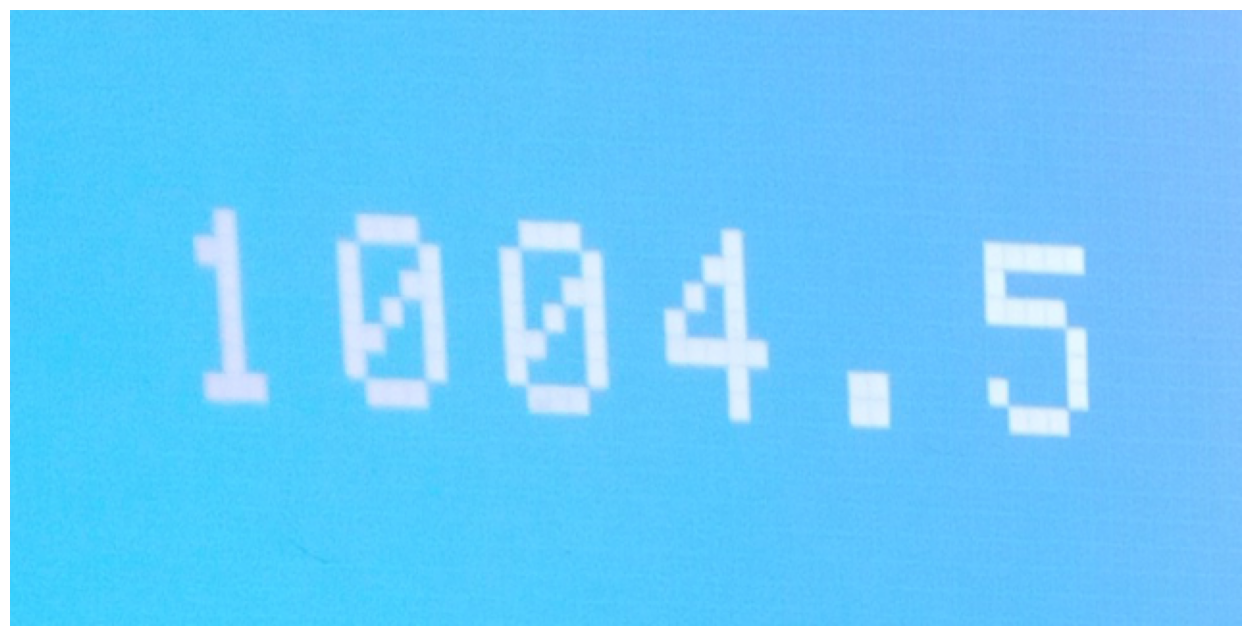

In [22]:
show_img(orig)

In [39]:
# show_img(roi)
# print(len(roi))
# roi.shape



print(np.empty(roi))

70.0


In [28]:
len(not_written), len(written), len(unusual)
print(len(not_written) + len(written) + len(unusual))

14


In [29]:
unusual

[]

In [30]:
not_written

[]

In [64]:
print(len(roi), len(roi[0]))

86 0


In [4]:
from platform import python_version
print(python_version())

3.8.13
